In [2]:
import numpy as np
import matplotlib.pyplot as plt

import fenics as fe

import sys
sys.path.insert(0, "../scripts")

from sfmcmc.nonlinear_poisson import NonlinearPoisson1D

In [3]:
nx = 64
pois = NonlinearPoisson1D(nx)
pois.setup_G(0.05)
I = np.eye(pois.n_dofs)

u = fe.TrialFunction(pois.V)
v = fe.TestFunction(pois.V)
A = fe.assemble(fe.inner(fe.grad(u), fe.grad(v)) * fe.dx)
pois.bc.apply(A)
A = A.array()

pois.u.vector()[:] = 1.
pois.u.vector()[pois.bc_dofs] = 0.

u = pois.u.vector()[:]
J = fe.assemble(pois.J).array()
T = J - A

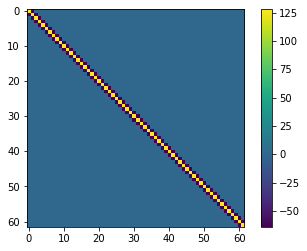

In [4]:
plt.imshow(A[1:-2, 1:-2])
plt.colorbar()
plt.show()

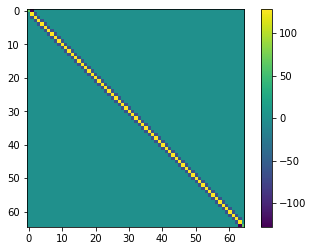

In [5]:
plt.imshow(T)
plt.colorbar()
plt.show()

Checking that our calculation is OK (modulo boundaries)

In [6]:
T.diagonal() - 2 * u**2 * nx

array([63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 63.])

In [7]:
vals, vecs = np.linalg.eig(A[1:-2, 1:-2])

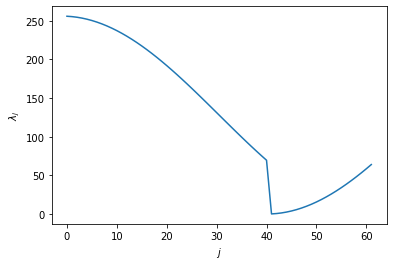

In [8]:
plt.plot(vals)
plt.xlabel("$j$")
plt.ylabel("$\lambda_j$")
plt.show()

In [9]:
print(vals.min())

0.15911408397788018


In [10]:
np.linalg.cond(A[1:-2, 1:-2])

1607.9084862876919

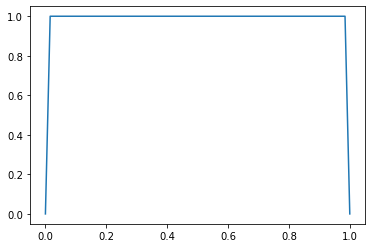

In [11]:
plt.plot(pois.x_dofs, u)
plt.show()

To compute the Hessian we need to the derivatve with respect to a 

0.0
0.0
0.0
0.0
0.0


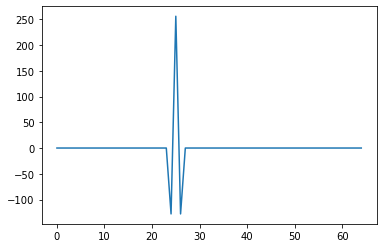

In [12]:
test_directions = [5, 10, 15, 20, 25]

for t in test_directions:
    d = fe.Function(pois.V)
    d.vector()[t] = 1.
    
    H = fe.assemble(fe.derivative(pois.J, pois.u, d))
    print(H.array()[t, t] - (4 * u[t] * nx))
    
plt.plot(H.array()[:, t])
plt.show()

Now we can run a basic gradient descent algorithm to see how things converge:

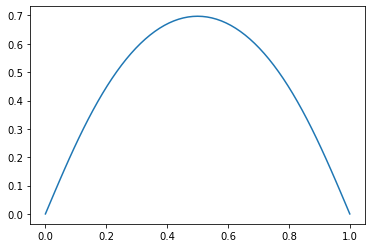

In [13]:
pois.solver.solve()
fe.plot(pois.u)
plt.show()

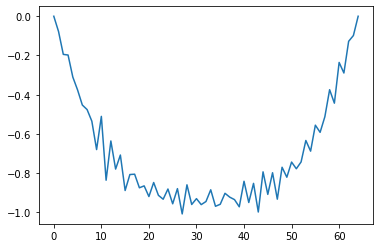

In [14]:
grad_map = pois.grad_phi(pois.u.vector()[:])
plt.plot(grad_map)
plt.show()

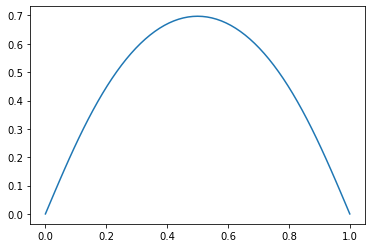

In [20]:
pois.setup_pc()
plt.plot(pois.x_dofs, pois.u.vector()[:])
plt.show()

In [152]:
nx = 128
eta = 1e-4
n_sample = 100

pois = NonlinearPoisson1D(nx)
pois.setup_G(1.)
pois.setup_pc()

u_exact = pois.u.vector()[:]
u_samples = np.zeros((pois.n_dofs, n_sample))

pois.u_curr[:] = 0.

In [153]:
for i in range(n_sample):
    if pois.u_curr.max() >= 1e6:
        print("\nULA diverged --- exiting")
        break
        
    if i % 100 == 0:
        print(f"\rIteration {i} of {n_sample}", end="")
    
    pois.ula_step(eta)
    u_samples[:, i] = pois.u_curr

Iteration 0 of 100
ULA diverged --- exiting


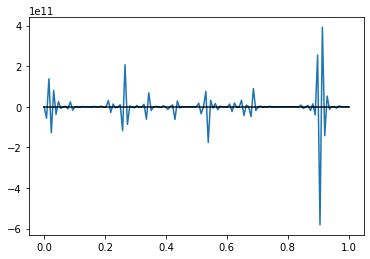

In [154]:
plt.plot(pois.x_dofs, pois.u_curr)
plt.plot(pois.x_dofs, u_samples[:, -1000:], alpha=0.01, color="black")
plt.show()

In [155]:
n_sample = 100

pula_samples = np.zeros((pois.n_dofs, n_sample))
pois.u_curr[:] = u_exact
eta_large = 0.05

for i in range(n_sample):
    if i % 100 == 0:
        print(f"\rIteration {i} of {n_sample}", end="")
        
    pois.pula_step(eta_large)
    pula_samples[:, i] = pois.u_curr

Iteration 0 of 100

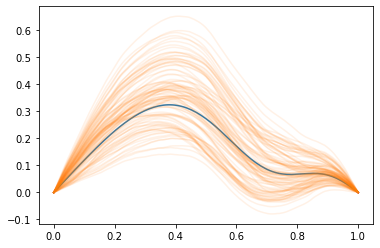

In [156]:
plt.plot(pois.x_dofs, u_exact, label="exact")
plt.plot(pois.x_dofs, pula_samples, color="tab:orange", alpha=0.1, label="pULA est.")
plt.show()